In [1]:
import polars as pl
import numpy as np
from typing import List

def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # 观测噪声协方差（越小越信）
        Q: float = 1e-5   # 过程噪声协方差（越小越稳）
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)      # 估计值
    P = np.zeros(n)          # 估计误差协方差
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # 预测更新
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # 观测更新
        K = P_minus / (P_minus + R)  # 卡尔曼增益
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)

# 判断序列是收敛、发散还是混沌系统：
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)

def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1 : i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)

def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series

def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")

def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")

def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")

def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")

def spread_product_expr(a: str, b: str) -> pl.Expr:
    return ((pl.col(a) - pl.col(b)) * (pl.col(a) + pl.col(b))).alias(f"{a}_SPREAD_X_MAG_{b}")

def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
        ])

    return single_exprs

def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b,),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [ ]:
import polars as pl


def cal_z_score(x: pl.Expr, mean: pl.Expr, std: pl.Expr) -> pl.Expr:
    return (x - mean) / std


def scaled_sigmoid_expr(x: pl.Expr, start: pl.Expr, end: pl.Expr) -> pl.Expr:
    n = (start - end).abs()
    score = pl.lit(2) / (
            pl.lit(1) + (pl.lit(2.71828) ** (-pl.lit(40_0000).log(10) * ((x - start - n) / n) + pl.lit(5e-3).log(10)))
    )
    return score / pl.lit(2)


def rolling_scaled_sigmoid_expr(x: str, mean: str, std: str) -> pl.Expr:
    return (
        pl.when(pl.col(std) == 0)
        .then(pl.lit(0.5))
        .otherwise(
            scaled_sigmoid_expr(cal_z_score(pl.col(x), pl.col(mean), pl.col(std)), pl.lit(-2.), pl.lit(2.))
        )
        .alias(f"{x}_scaled")  # 列命名
    )

def rolling_sum_expr(col_name: str, window: int) -> pl.Expr:
    return pl.col(col_name).rolling_sum(window).alias(f"{col_name}_sum_{window}")

def rolling_normalize_data(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
           and not (col.endswith('_rolling_mean') or col.endswith('_rolling_std') or col.endswith('_scaled'))
    ]

    normalized_df = rollin_df.with_columns(
        [
            pl.col(column).rolling_mean(window).alias(f"{column}_rolling_mean")
            for column in columns_to_normalize
        ] + [
            pl.col(column).rolling_std(window).alias(f"{column}_rolling_std")
            for column in columns_to_normalize
        ]
    ).with_columns(
        rolling_scaled_sigmoid_expr(column, f"{column}_rolling_mean", f"{column}_rolling_std")
        for column in columns_to_normalize
    )
    return normalized_df

In [2]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # 新增 datetime 列，不覆盖原始时间戳
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # 按周截断，用新的 datetime 列
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1").alias("week_start")
    ])

    # 获取唯一周
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # 每周筛选子 DataFrame，保留所有列
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def split_df_by_month(
        df: pl.DataFrame, 
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        df.filter(pl.col("month_start") == mo).drop("month_start")
        for mo in unique_months["month_start"]
    ]

    return monthly_dfs


In [3]:
import pandas as pd

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 3000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()
    
    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

In [4]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.0005_rolling200.csv")

In [5]:
# 假设你已有 df
monthly_dataframes = split_df_by_month(origin_df)
print(f"共拆成 {len(monthly_dataframes)} 个月数据帧")


共拆成 2 个月数据帧


In [6]:
monthly_dataframes[0]

timestamp,price,sum_buy_size,sum_sell_size,timestamp_duration,price_pct_change,buy_sell_imbalance,alt_top_long_short_account_ratio_data_longShortRatio,alt_top_long_short_position_ratio_data_longShortRatio,alt_trade_taker_long_short_ratio_data_buySellRatio,alt_long_short_ratio_data_longShortRatio,alt_open_interest_data_sumOpenInterest,alt_open_interest_data_sumOpenInterestValue,alt_factor_short_term_oi_trend,alt_factor_long_term_oi_trend,impact_price_pct_ask_imn,impact_price_pct_bid_imn,mid_price,spread,far_bid_price,far_ask_price,best_bid_price,best_ask_price,best_bid_amount,best_ask_amount,real_bid_amount_sum,real_ask_amount_sum,ret_mean_50,ret_mean_100,volatility_100,buy_sell_ratio,avg_buy_size_200,avg_sell_size_200,rolling_px_pct_sum_200,px_short_term_oi_divergence,oi_trend_slope,impact_momentum,impact_sensitivity,momentum_confirmed_by_orderflow,oi_breakout_signal,timestamp_dt
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
1743939741056000,82724.9,63.539,7.48,1.5688e7,0.000515,56.059,1.7435,1.8153,4.0373,1.5458,70917.681,5.8607e9,70900.314,70849.796625,0.0,0.0,82724.95,0.1,82722.5,82729.4,82724.9,82725.0,21.588,1.022,1.977,4.289,-0.000052,-0.000079,178.657318,0.789352,175.55267,187.31843,-0.00937,-1.3215e-7,50.517375,-0.665423,-0.000132,-0.007396,8.7937e-8,2025-04-06 11:42:21.056
1743940210475000,82680.1,395.821,259.278,4.69419e8,-0.000542,136.543,1.7465,1.8222,3.4695,1.5497,70920.112,5.8657e9,70899.0415,70862.41325,0.0,0.0,82680.05,0.1,82676.6,82683.9,82680.0,82680.1,1.496,25.857,0.816,4.45,-0.000074,-0.00008,174.597722,0.208431,177.343465,188.59641,-0.010437,-1.4721e-7,36.62825,-6.837208,-0.000016,-0.002175,0.000001,2025-04-06 11:50:10.475
1743940436296000,82726.3,146.192,113.842,2.25821e8,0.000559,32.35,1.7465,1.8222,3.4695,1.5497,70920.112,5.8657e9,70899.0415,70862.41325,0.000006,0.0,82726.25,0.1,82724.2,82729.6,82726.2,82726.3,2.045,0.042,78.218,0.561,-0.000073,-0.000079,168.447823,0.124407,177.61681,188.63459,-0.009353,-1.3192e-7,36.62825,-2.432019,-0.000036,-0.001164,3.2082e-7,2025-04-06 11:53:56.296
1743940481646000,82767.8,106.737,14.847,4.535e7,0.000502,91.89,1.7465,1.8222,3.4695,1.5497,70920.112,5.8657e9,70899.0415,70862.41325,0.0,0.0,82767.85,0.1,82764.6,82772.3,82767.8,82767.9,22.16,0.369,47.932,3.28,-0.000073,-0.000069,162.696948,0.755774,177.856895,188.23446,-0.008328,-1.1746e-7,36.62825,-1.012518,-0.000068,-0.006294,1.1893e-7,2025-04-06 11:54:41.646
1743940493529000,82814.9,75.054,3.979,1.1883e7,0.000569,71.075,1.7465,1.8222,3.4695,1.5497,70920.112,5.8657e9,70899.0415,70862.41325,0.0,0.0,82814.85,0.1,82809.8,82818.0,82814.8,82814.9,7.439,11.634,3.079,11.76,-0.000051,-0.000058,157.547216,0.899308,176.753495,186.563065,-0.00827,-1.1665e-7,36.62825,-0.653624,-0.000105,-0.007438,7.6244e-8,2025-04-06 11:54:53.529
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1746056768281000,94154.0,53.762,29.545,6.6922e7,0.000522,24.217,0.8797,1.4485,3.6426,0.7784,80082.986,7.5380e9,80173.410083,81039.448569,0.0,0.0,94153.95,0.1,94150.0,94158.8,94153.9,94154.0,13.463,1.847,4.651,0.347,-0.000095,-0.000047,217.790299,0.290696,106.571545,108.917165,-0.001507,-1.8801e-8,-866.038486,-0.125575,-0.000018,-0.000438,2.3610e-9,2025-04-30 23:46:08.281
1746057039541000,94201.1,259.965,105.668,2.7126e8,0.0005,154.297,0.8793,1.4488,0.7308,0.7781,80113.409,7.5451e9,80153.48725,81014.032306,0.000003,0.0,94201.15,0.1,94197.4,94205.7,94201.1,94201.2,4.789,0.01,65.951,0.167,-0.000095,-0.000047,217.116502,0.422,107.70634,109.32905,-0.001511,-1.8849e-8,-860.545056,-0.552416,-0.000004,-0.000638,1.0413e-8,2025-04-30 23:50:39.541
1746057263664000,94153.9,89.971,132.777,2.24123e8,-0.000501,-42.806,0.8793,1.4488,0.7308,0.7781,80113.409,7.5451e9,80153.48725,81014.032306,0.0,0.0,94153.95,0.1,94151.3,94157.4,94153.9,94154.0,2.761,27.619,0.191,13.24,-0.000095,-0.000057,216.137978,-0.192172,107.98418

In [7]:
raw_df = batch_apply_transforms(monthly_dataframes[0], 200, 1)


In [8]:
print(f"Polars DataFrame size: {raw_df.estimated_size() / (1024 ** 2):.4f} MB")

raw_df

Polars DataFrame size: 1506.9986 MB


timestamp,price,sum_buy_size,sum_sell_size,timestamp_duration,price_pct_change,buy_sell_imbalance,alt_top_long_short_account_ratio_data_longShortRatio,alt_top_long_short_position_ratio_data_longShortRatio,alt_trade_taker_long_short_ratio_data_buySellRatio,alt_long_short_ratio_data_longShortRatio,alt_open_interest_data_sumOpenInterest,alt_open_interest_data_sumOpenInterestValue,alt_factor_short_term_oi_trend,alt_factor_long_term_oi_trend,impact_price_pct_ask_imn,impact_price_pct_bid_imn,mid_price,spread,far_bid_price,far_ask_price,best_bid_price,best_ask_price,best_bid_amount,best_ask_amount,real_bid_amount_sum,real_ask_amount_sum,ret_mean_50,ret_mean_100,volatility_100,buy_sell_ratio,avg_buy_size_200,avg_sell_size_200,rolling_px_pct_sum_200,px_short_term_oi_divergence,oi_trend_slope,impact_momentum,…,oi_trend_slope_X_impact_momentum_cond_dev_rolling200,oi_trend_slope_X_impact_sensitivity,oi_trend_slope_DIV_impact_sensitivity,oi_trend_slope_SPREAD_X_MAG_impact_sensitivity,oi_trend_slope_X_impact_sensitivity_cond_dev_rolling200,oi_trend_slope_X_momentum_confirmed_by_orderflow,oi_trend_slope_DIV_momentum_confirmed_by_orderflow,oi_trend_slope_SPREAD_X_MAG_momentum_confirmed_by_orderflow,oi_trend_slope_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,oi_trend_slope_X_oi_breakout_signal,oi_trend_slope_DIV_oi_breakout_signal,oi_trend_slope_SPREAD_X_MAG_oi_breakout_signal,oi_trend_slope_X_oi_breakout_signal_cond_dev_rolling200,impact_momentum_X_impact_sensitivity,impact_momentum_DIV_impact_sensitivity,impact_momentum_SPREAD_X_MAG_impact_sensitivity,impact_momentum_X_impact_sensitivity_cond_dev_rolling200,impact_momentum_X_momentum_confirmed_by_orderflow,impact_momentum_DIV_momentum_confirmed_by_orderflow,impact_momentum_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_momentum_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_momentum_X_oi_breakout_signal,impact_momentum_DIV_oi_breakout_signal,impact_momentum_SPREAD_X_MAG_oi_breakout_signal,impact_momentum_X_oi_breakout_signal_cond_dev_rolling200,impact_sensitivity_X_momentum_confirmed_by_orderflow,impact_sensitivity_DIV_momentum_confirmed_by_orderflow,impact_sensitivity_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_sensitivity_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_sensitivity_X_oi_breakout_signal,impact_sensitivity_DIV_oi_breakout_signal,impact_sensitivity_SPREAD_X_MAG_oi_breakout_signal,impact_sensitivity_X_oi_breakout_signal_cond_dev_rolling200,momentum_confirmed_by_orderflow_X_oi_breakout_signal,momentum_confirmed_by_orderflow_DIV_oi_breakout_signal,momentum_confirmed_by_orderflow_SPREAD_X_MAG_oi_breakout_signal,momentum_confirmed_by_orderflow_X_oi_breakout_signal_cond_dev_rolling200
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1743939741056000,82724.9,63.539,7.48,1.5688e7,0.000515,56.059,1.7435,1.8153,4.0373,1.5458,70917.681,5.8607e9,70900.314,70849.796625,0.0,0.0,82724.95,0.1,82722.5,82729.4,82724.9,82725.0,21.588,1.022,1.977,4.289,-0.000052,-0.000079,178.657318,0.789352,175.55267,187.31843,-0.00937,-1.3215e-7,50.517375,-0.665423,…,0.0,-0.006665,-382935.073149,2552.005177,0.0,-0.373624,-6830.420906,2552.005122,0.0,0.000004,5.1581e8,2552.005177,0.0,0.000088,5044.080758,0.442787,0.0,0.004921,89.971374,0.442733,0.0,-5.8515e-8,-6.7944e6,0.442787,0.0,9.7576e-7,0.017838,-0.000055,0.0,-1.1602e-11,-1347.103256,1.7406e-8,0.0,-6.5038e-10,-75517.261408,0.000055,0.0
1743940210475000,82680.1,395.821,259.278,4.69419e8,-0.000542,136.543,1.7465,1.8222,3.4695,1.5497,70920.112,5.8657e9,70899.0415,70862.41325,0.0,0.0,82680.05,0.1,82676.6,82683.9,82680.0,82680.1,1.496,25.857,0.816,4.45,-0.000074,-0.00008,174.597722,0.208431,177.343465,188.59641,-0.010437,-1.4721e-7,36.62825,-6.837208,…,0.0,-0.000584,-2.

In [9]:
from tqdm import tqdm

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
                
        if steps != -1:
            steps_list.append(steps)
            
    if len(steps_list) == 0:
        return -1
        
    return int(np.mean(steps_list))

prices_np = raw_df["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的均值步数:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的均值步数:", avg_steps_2pct)


cal abs change 0.50% avg steps: 100%|████████████████████████████████████████████████████████████████████| 55549/55549 [00:00<00:00, 59657.81it/s]


波动 ±0.5% 的均值步数: 92


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 55549/55549 [00:03<00:00, 17408.21it/s]


波动 ±1% 的均值步数: 322


cal abs change 2.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 55549/55549 [00:13<00:00, 4244.63it/s]

波动 ±2% 的均值步数: 1259


In [10]:
avg_steps_2pct = 2000

In [11]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

raw_df = raw_df.with_columns([
    # future_return_expr("price", avg_steps_05pct),
    # future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [12]:
cleaned_df = clean_df_drop_nulls(raw_df)


各列空值数量：
price_lyap_200                             199
price_fft_power_top3                       199
sum_buy_size_lyap_200                      199
sum_buy_size_fft_power_top3                199
sum_sell_size_lyap_200                     199
                                          ... 
oi_breakout_signal_second_order_diff_1       2
oi_breakout_signal_momentum_ratio_1          1
oi_breakout_signal_lag_1                     1
oi_breakout_signal_skew_shift_200          200
future_return_2000                        2000
Length: 391, dtype: int64
删除空值超过 3000 的列：['alt_top_long_short_account_ratio_data_longShortRatio_skew_shift_200', 'oi_trend_slope_skew_shift_200']
删除列后，DataFrame形状：(55549, 3550)
空值最多的列是：alt_top_long_short_account_ratio_data_longShortRatio_skew_shift_200，共有 3724 个空值
删除空值行后，DataFrame形状：(50078, 3550)


In [13]:
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol']


In [14]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str, exclude_prefixes: list[str]) -> dict:
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict


In [15]:
# ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_05pct}", exclude_prefixes)
# # 按 IC 值排序（降序）
# sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

# print("Top 20 features by IC:")
# for feat, ic in sorted_ic[:20]:
#     print(f"{feat}: {ic:.6f}")

# print("\nBottom 20 features by IC:")
# for feat, ic in reversed(sorted_ic[-20:]):
#     print(f"{feat}: {ic:.6f}")


In [16]:
# ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_1pct}", exclude_prefixes)
# # 按 IC 值排序（降序）
# sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

# print("Top 20 features by IC:")
# for feat, ic in sorted_ic[:20]:
#     print(f"{feat}: {ic:.6f}")

# print("\nBottom 20 features by IC:")
# for feat, ic in reversed(sorted_ic[-20:]):
#     print(f"{feat}: {ic:.6f}")


In [17]:
ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_2pct}", exclude_prefixes)
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


Calculating IC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3547/3547 [00:02<00:00, 1457.57it/s]

Top 20 features by IC:
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.423164
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.422777
alt_factor_long_term_oi_trend_DIV_mid_price: 0.422356
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.421914
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.421210
alt_open_interest_data_sumOpenInterest_DIV_far_ask_price: 0.415667
alt_open_interest_data_sumOpenInterest_DIV_best_ask_price: 0.415486
alt_open_interest_data_sumOpenInterest_DIV_mid_price: 0.415218
alt_open_interest_data_sumOpenInterest_DIV_best_bid_price: 0.414938
alt_open_interest_data_sumOpenInterest_DIV_far_bid_price: 0.414575
alt_factor_short_term_oi_trend_DIV_far_ask_price: 0.394870
alt_factor_short_term_oi_trend_DIV_best_ask_price: 0.394566
alt_factor_short_term_oi_trend_DIV_mid_price: 0.394215
alt_factor_short_term_oi_trend_DIV_best_bid_price: 0.393845
alt_factor_short_term_oi_trend_DIV_far_bid_price: 0.393247
alt_open_interest_data_sumOpenInterest_SPREAD_X_MAG_far_ask_pri

In [18]:
def calc_hourly_rankic(
    df_to_cal_rankic: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df_to_cal_rankic.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]
    
    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"),
                    method="spearman").alias(factor)
        )
        
    ic_df = (
        df_to_cal_rankic
        .with_columns([
            pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us")),
        ])
        .with_columns([
            pl.col(timestamp_col).dt.truncate("1h").alias("hour_group"),
        ])
        .group_by("hour_group")
        .agg(agg_exprs)
        .sort("hour_group")
    )
    
    
    return ic_df

In [19]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    # 使用 pl.DataFrame.select 批量计算 mean 和 std
    means = ic_df.select([pl.col(col).mean().alias(col) for col in factor_cols])
    stds = ic_df.select([pl.col(col).std().alias(col) for col in factor_cols])

    # 构造结果
    data = []
    for col in factor_cols:
        mean_ic = means[0, col]
        std_ic = stds[0, col]
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": col, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})

    return pl.DataFrame(data)


In [20]:
target_col = f"future_return_{avg_steps_2pct}"

exclude_cols = exclude_prefixes + ['hour_group']

ic_hourly = calc_hourly_rankic(
    cleaned_df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


shape: (532, 3_548)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed ┆ momentum_confirmed ┆ momentum_confirmed ┆ momentum_confirmed │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _by_orderflo…      ┆ _by_orderflo…      ┆ _by_orderflo…      ┆ _by_orderflo…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-06   ┆ -0.692082 ┆ 0.098974     ┆ 0.608504      ┆ … ┆ 0.66239            ┆ 0.25879

In [21]:
def print_top_bottom_ic_ir(
    ic_summary: pl.DataFrame,
    top_n: int = 5
):
    pdf = ic_summary.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])
    
    def format_rows(rows, metric_name):
        max_len = max(len(row['factor']) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    ic_top = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient="records")
    ic_bottom = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient="records")
    ir_top = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient="records")
    ir_bottom = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient="records")

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top, "ir")), end="\n\n")

    # 同时返回因子名列表（如需进一步操作）
    ic_top_names = [row["factor"] for row in ic_top]
    ic_bot_names = [row["factor"] for row in ic_bottom]

    ir_top_names = [row["factor"] for row in ir_top]
    return ic_top_names, ic_bot_names, ir_top_names


In [22]:
ic_summary = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(ic_summary)
ic_top_rank, ic_bot_rank, ir_top_rank = print_top_bottom_ic_ir(ic_summary, top_n=10)


shape: (3_391, 4)
┌─────────────────────────────────┬───────────┬──────────┬───────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ ir        │
│ ---                             ┆ ---       ┆ ---      ┆ ---       │
│ str                             ┆ f64       ┆ f64      ┆ f64       │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╡
│ sum_buy_size                    ┆ -0.052802 ┆ 0.244463 ┆ -0.215993 │
│ sum_sell_size                   ┆ 0.062726  ┆ 0.233052 ┆ 0.269152  │
│ price_pct_change                ┆ -0.148963 ┆ 0.194467 ┆ -0.766006 │
│ buy_sell_imbalance              ┆ -0.15078  ┆ 0.268887 ┆ -0.560758 │
│ alt_top_long_short_account_rat… ┆ NaN       ┆ NaN      ┆ NaN       │
│ …                               ┆ …         ┆ …        ┆ …         │
│ impact_sensitivity_X_oi_breako… ┆ NaN       ┆ NaN      ┆ NaN       │
│ momentum_confirmed_by_orderflo… ┆ 0.00163   ┆ 0.271713 ┆ 0.005998  │
│ momentum_confirmed_by_orderflo… ┆ -0.003758 ┆ 0.253592 ┆ 

In [23]:
cleaned_df


timestamp,price,sum_buy_size,sum_sell_size,timestamp_duration,price_pct_change,buy_sell_imbalance,alt_top_long_short_account_ratio_data_longShortRatio,alt_top_long_short_position_ratio_data_longShortRatio,alt_trade_taker_long_short_ratio_data_buySellRatio,alt_long_short_ratio_data_longShortRatio,alt_open_interest_data_sumOpenInterest,alt_open_interest_data_sumOpenInterestValue,alt_factor_short_term_oi_trend,alt_factor_long_term_oi_trend,impact_price_pct_ask_imn,impact_price_pct_bid_imn,mid_price,spread,far_bid_price,far_ask_price,best_bid_price,best_ask_price,best_bid_amount,best_ask_amount,real_bid_amount_sum,real_ask_amount_sum,ret_mean_50,ret_mean_100,volatility_100,buy_sell_ratio,avg_buy_size_200,avg_sell_size_200,rolling_px_pct_sum_200,px_short_term_oi_divergence,oi_trend_slope,impact_momentum,…,oi_trend_slope_X_impact_sensitivity,oi_trend_slope_DIV_impact_sensitivity,oi_trend_slope_SPREAD_X_MAG_impact_sensitivity,oi_trend_slope_X_impact_sensitivity_cond_dev_rolling200,oi_trend_slope_X_momentum_confirmed_by_orderflow,oi_trend_slope_DIV_momentum_confirmed_by_orderflow,oi_trend_slope_SPREAD_X_MAG_momentum_confirmed_by_orderflow,oi_trend_slope_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,oi_trend_slope_X_oi_breakout_signal,oi_trend_slope_DIV_oi_breakout_signal,oi_trend_slope_SPREAD_X_MAG_oi_breakout_signal,oi_trend_slope_X_oi_breakout_signal_cond_dev_rolling200,impact_momentum_X_impact_sensitivity,impact_momentum_DIV_impact_sensitivity,impact_momentum_SPREAD_X_MAG_impact_sensitivity,impact_momentum_X_impact_sensitivity_cond_dev_rolling200,impact_momentum_X_momentum_confirmed_by_orderflow,impact_momentum_DIV_momentum_confirmed_by_orderflow,impact_momentum_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_momentum_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_momentum_X_oi_breakout_signal,impact_momentum_DIV_oi_breakout_signal,impact_momentum_SPREAD_X_MAG_oi_breakout_signal,impact_momentum_X_oi_breakout_signal_cond_dev_rolling200,impact_sensitivity_X_momentum_confirmed_by_orderflow,impact_sensitivity_DIV_momentum_confirmed_by_orderflow,impact_sensitivity_SPREAD_X_MAG_momentum_confirmed_by_orderflow,impact_sensitivity_X_momentum_confirmed_by_orderflow_cond_dev_rolling200,impact_sensitivity_X_oi_breakout_signal,impact_sensitivity_DIV_oi_breakout_signal,impact_sensitivity_SPREAD_X_MAG_oi_breakout_signal,impact_sensitivity_X_oi_breakout_signal_cond_dev_rolling200,momentum_confirmed_by_orderflow_X_oi_breakout_signal,momentum_confirmed_by_orderflow_DIV_oi_breakout_signal,momentum_confirmed_by_orderflow_SPREAD_X_MAG_oi_breakout_signal,momentum_confirmed_by_orderflow_X_oi_breakout_signal_cond_dev_rolling200,future_return_2000
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1743961808254000,81100.9,4.091,32.729,2.051e6,-0.000516,-28.638,2.2404,1.7486,0.5927,1.9121,73360.483,5.9539e9,72854.151,71938.036042,0.0,0.000001,81100.85,0.1,81098.0,81106.4,81100.8,81100.9,0.3,18.436,13.379,5.144,0.000042,-0.000034,163.282167,-0.777784,88.933675,105.30605,-0.016496,-2.2643e-7,916.114958,-0.607395,…,-0.410444,-2.0448e6,839266.616882,0.0,11.754288,71400.834829,839266.616717,0.0,0.000126,6.2096e9,839266.616882,0.0,0.000272,1355.742697,0.368929,0.0,-0.007793,-47.339597,0.368764,0.0,-8.3536e-8,-4.1170e6,0.368929,0.0,-0.000006,-0.034919,-0.000164,0.0,-6.1618e-11,-3036.804511,2.0073e-7,0.0,1.7646e-9,86968.007599,0.000165,1.7646e-9,-0.043574
1743961812617000,81060.0,2.154,38.085,4.363e6,-0.000504,-35.931,2.2404,1.7486,0.5927,1.9121,73360.483,5.9539e9,72854.151,71938.036042,0.0,0.0,81060.05,0.1,81055.0,81064.4,81060.0,81060.1,0.581,21.394,1.851,3.912,0.000018,-0.000034,161.957796,-0.89294,88.71344,105.08189,-0.0165,-2.2648e-7,916.114958,-0.663933,…,-0.375647,-2.2342e6,839266.616882,0.

In [24]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

def calc_monotonicity(bin_returns) -> float:
    bins = list(range(len(bin_returns)))
    rho, _ = spearmanr(bins, bin_returns)
    return rho

def calc_binned_return_and_stability(
    df: pl.DataFrame,
    future_return_col: str,
    exclude_prefixes: list[str] = None,
    n_bins: int = 50,
):
    if exclude_prefixes is None:
        exclude_prefixes = []

    factors = [
        col for col in df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    pdf = df.select([*factors, future_return_col]).to_pandas().dropna()

    results = []

    for factor in factors:
        try:
            pdf['factor_bin'] = pd.qcut(pdf[factor], q=n_bins, duplicates='drop')
            grouped = pdf.groupby('factor_bin', observed=False)[future_return_col].agg(['mean', 'std']).reset_index()

            if len(grouped) < 40:
                continue
                
            bin_means = grouped['mean'].tolist()
            spread = bin_means[-1] - bin_means[0]
            mean_std = grouped['std'].mean()
            mean_mean = grouped['mean'].mean()
            stability = mean_std / abs(mean_mean) if mean_mean != 0 else np.nan
            monotonicity = calc_monotonicity(bin_means)

            results.append({
                'factor': factor,
                'spread': spread,
                'stability': stability,
                'monotonicity': monotonicity,
                'mean_return_top_bin': bin_means[-1],
                'mean_return_bottom_bin': bin_means[0],
                'bin_returns': bin_means,
            })
            
        except Exception as e:
            print(f"Skipped factor {factor} due to error: {e}")
            continue

    results_sorted_by_spread = sorted(results, key=lambda x: x['spread'], reverse=True)
    results_sorted_by_stability = sorted(results, key=lambda x: x['stability'] if not np.isnan(x['stability']) else 1e9)
    results_sorted_by_monotonicity = sorted(results, key=lambda x: abs(x['monotonicity']), reverse=True)
    return {
        'by_spread': results_sorted_by_spread,
        'by_stability': results_sorted_by_stability,
        'by_monotonicity': results_sorted_by_monotonicity,
        'raw': results
    }


In [25]:
res = calc_binned_return_and_stability(cleaned_df, future_return_col=target_col, exclude_prefixes=exclude_cols, n_bins=50)

print("按收益差排名Top 5：")
for r in res['by_spread'][:50]:
    print(r['factor'], r['spread'])

print("\n按平稳度排名Top 5：")
for r in res['by_stability'][:50]:
    print(r['factor'], r['stability'])

print("\n按单调性排名Top 5：")
for r in res['by_monotonicity'][:50]:
    print(r['factor'], r['monotonicity'])


按收益差排名Top 5：
alt_top_long_short_position_ratio_data_longShortRatio_X_avg_sell_size_200 0.0450967562773818
sum_buy_size_kalman 0.04444728779801144
sum_sell_size_lyap_200 0.04389023237205787
oi_trend_slope_lyap_200 0.04354378295161904
sum_sell_size_kalman 0.04264179668471116
alt_top_long_short_position_ratio_data_longShortRatio_X_avg_buy_size_200 0.04182167460344837
alt_factor_short_term_oi_trend_volatility_200 0.04132112543254211
avg_buy_size_200_SPREAD_X_MAG_impact_sensitivity 0.04101543312690669
avg_buy_size_200 0.040998373617789574
avg_buy_size_200_squared 0.040998373617789574
avg_buy_size_200_abs 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_rolling_px_pct_sum_200 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_momentum_confirmed_by_orderflow 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_oi_breakout_signal 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_impact_momentum 0.040944548325272855

In [26]:
A = ['alt_open_interest_data_sumOpenInterestValue_fft_power_top3', 'alt_open_interest_data_sumOpenInterestValue', 'alt_open_interest_data_sumOpenInterestValue_X_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'mid_price', 'alt_factor_long_term_oi_trend_X_far_bid_price']
FC = 'price_volatility_200'

47.699497809661665 909.6882227513845


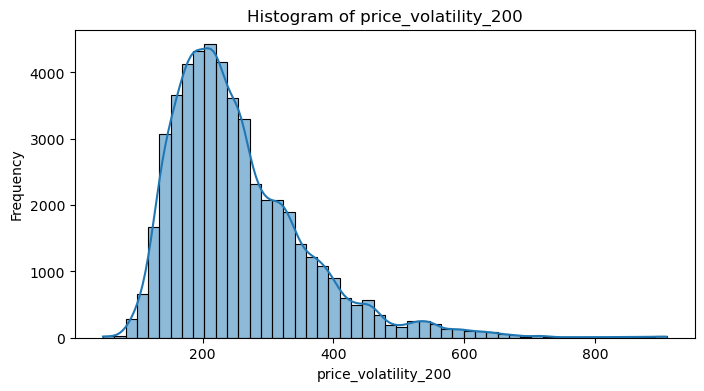

74487.6 95752.2


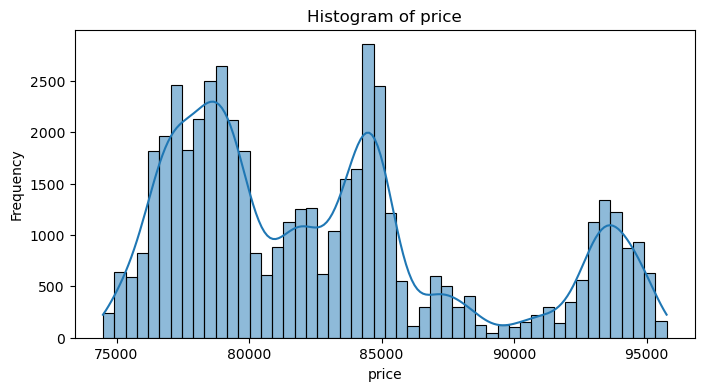

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_factor_histogram(df, factor_name, bins=50):
    data = df.select(pl.col(factor_name)).to_numpy().flatten()
    print(data.min(), data.max())  # 看看最小值和最大值
    plt.figure(figsize=(8,4))
    sns.histplot(data, bins=bins, kde=True)
    plt.title(f"Histogram of {factor_name}")
    plt.xlabel(factor_name)
    plt.ylabel("Frequency")
    plt.show()

plot_factor_histogram(cleaned_df, FC)
plot_factor_histogram(cleaned_df, "price")


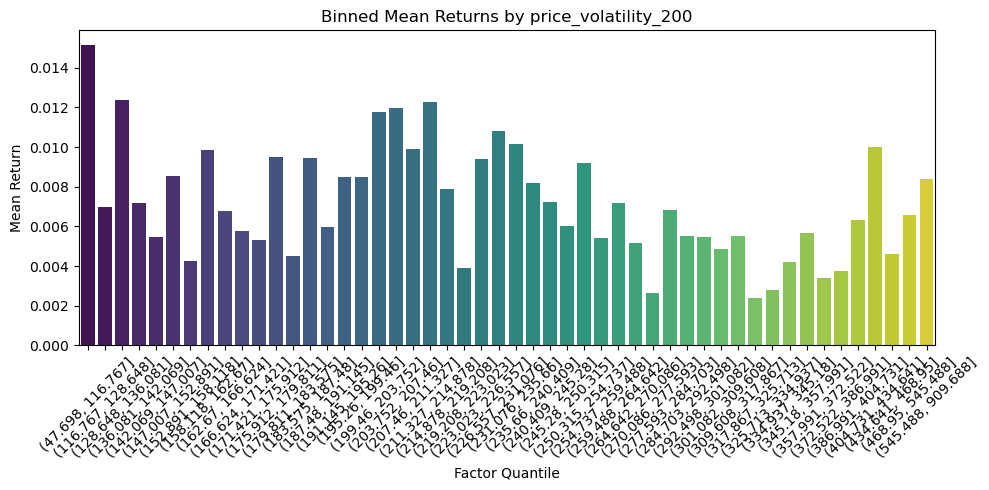

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_binned_returns(df: pl.DataFrame, factor_name: str, return_name: str, n_bins: int = 10):
    # 转为 pandas，便于分箱
    pdf = df.select([factor_name, return_name]).to_pandas()
    
    # 去除缺失值
    pdf = pdf.dropna()

    # 分箱（按因子值分为等分 quantile 桶）
    pdf["factor_bin"] = pd.qcut(pdf[factor_name], q=n_bins, duplicates="drop")

    # 计算每个分箱的平均收益
    bin_returns = pdf.groupby("factor_bin", observed=False)[return_name].mean().reset_index()
    # 可视化
    plt.figure(figsize=(10,5))
    sns.barplot(
        x=bin_returns["factor_bin"].astype(str),
        y=bin_returns[return_name],
        hue=bin_returns["factor_bin"].astype(str),  # 把 x 也设置为 hue
        palette="viridis",
        legend=False
    )   
    plt.xticks(rotation=45)
    plt.title(f"Binned Mean Returns by {factor_name}")
    plt.xlabel("Factor Quantile")
    plt.ylabel("Mean Return")
    plt.tight_layout()
    plt.show()

plot_binned_returns(cleaned_df, FC, target_col, n_bins=50)


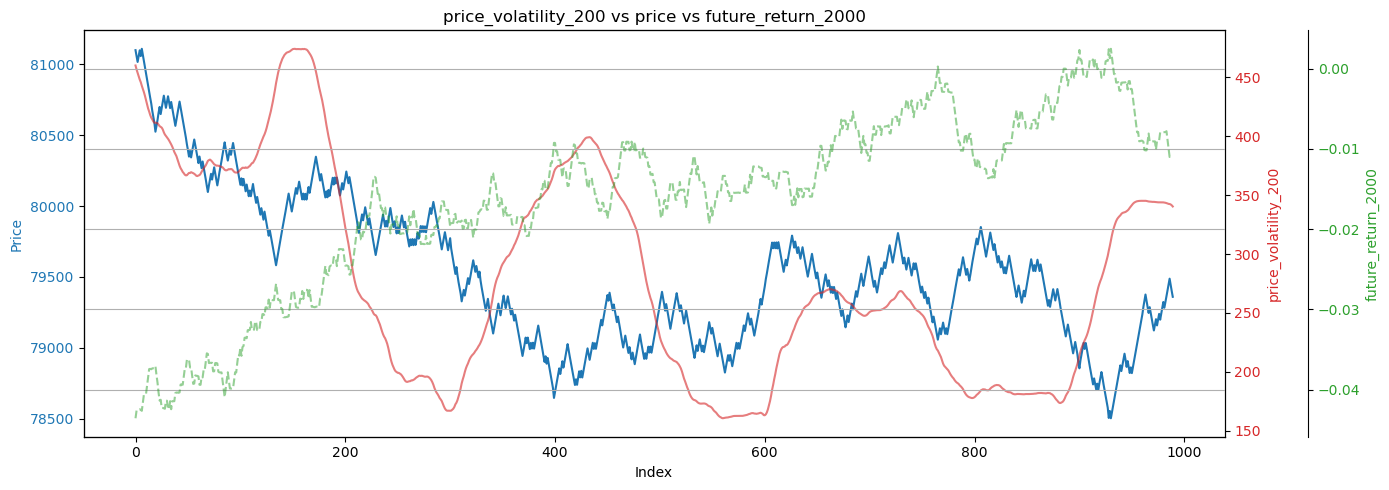

In [29]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).head(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # 第三个y轴往右偏移
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_factor_price_target(
    df=cleaned_df,
    factor_name=FC,
    price_col="price",
    target_col=target_col,
    n=990
)


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def single_asset_rolling_quantile_backtest(
    df,
    signal_col='signal',
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.9,
    short_quantile=0.1,
    window=500,
    fee=0.001,
    signal_mode='normal',
    plot=True,
):
    df = df.copy()
    if not np.issubdtype(df[timestamp_col].dtype, np.datetime64):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='us')
    df = df.sort_values(timestamp_col).reset_index(drop=True)

    if signal_mode == 'reverse':
        df[signal_col] = df[signal_col] * -1
        
    # 收益
    df['raw_ret'] = df[price_col].shift(-1) / df[price_col] - 1
    df = df.dropna(subset=['raw_ret'])

    # 滚动分位数（使用过去的数据）
    rolling = df[signal_col].rolling(window=window, min_periods=window)
    df['long_thresh'] = rolling.quantile(long_quantile)
    df['short_thresh'] = rolling.quantile(short_quantile)
    df = df.dropna(subset=['long_thresh', 'short_thresh'])

    # 仓位：信号必须翻转才换仓，避免闪烁
    df['position'] = 0
    pos = 0
    positions = []

    for i, row in df.iterrows():
        signal = row[signal_col]
        long_th = row['long_thresh']
        short_th = row['short_thresh']

        if signal > long_th and pos != 1:
            pos = 1  # 做多
        elif signal < short_th and pos != -1:
            pos = -1  # 做空
        # 否则保持原来仓位
        positions.append(pos)

    df['position'] = positions

    # 换仓手续费
    df['position_shift'] = df['position'].shift(1).fillna(0)
    df['turnover'] = (df['position'] != df['position_shift']).astype(int)
    df['strategy_ret'] = df['position_shift'] * df['raw_ret'] - df['turnover'] * fee
    df['cumulative'] = (1 + df['strategy_ret']).cumprod()
    df['buy_hold'] = df[price_col] / df[price_col].iloc[0]

    

    # ➕ 绩效指标
    trade_id = (df['position'] != df['position_shift']).cumsum()
    df['trade_id'] = trade_id
    trades = df[df['turnover'] == 1]
    trade_returns = []

    for tid in trades['trade_id'].unique():
        sub = df[df['trade_id'] == tid]
        if len(sub) > 1:
            trade_return = (1 + sub['strategy_ret']).prod() - 1
            trade_returns.append(trade_return)

    trade_returns = np.array(trade_returns)
    trade_count = len(trade_returns)
    win_rate = (trade_returns > 0).sum() / trade_count

    total_return = df['cumulative'].iloc[-1] - 1
    sharpe = df['strategy_ret'].mean() / df['strategy_ret'].std()
    max_dd = ((df['cumulative'].cummax() - df['cumulative']) / df['cumulative'].cummax()).max()
    total_fee = df['turnover'].sum() * fee

    if plot:
        print("\n📊 策略绩效指标:")
    
        print(f"总交易次数: {trade_count}")
        print(f"总手续费: {total_fee:.4f}（费率: {fee:.4f}）")
    
        print(f"胜率: {win_rate:.2%}")
        print(f"总收益: {total_return:.2%}")
        print(f"夏普比率: {sharpe:.2f}")
        print(f"最大回撤: {max_dd:.2%}")
    
        # 画净值曲线和持仓信号
        plt.figure(figsize=(14, 6))
        plt.plot(df[timestamp_col], df['cumulative'], label='Strategy')
        plt.plot(df[timestamp_col], df['buy_hold'], label='Buy & Hold', linestyle='--')
        plt.fill_between(df[timestamp_col], 0.98, 1.02, where=df['position'] == 1, color='green', alpha=0.1, label='Long')
        plt.fill_between(df[timestamp_col], 0.98, 1.02, where=df['position'] == -1, color='red', alpha=0.1, label='Short')
        plt.title('Rolling Quantile Backtest')
        plt.legend()
        plt.grid(True)
        plt.show()

    return df


In [31]:
def backtest_all_signals(
    df,
    signal_cols,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.95,
    short_quantile=0.05,
    window=500,
    fee=0.001,
    top_n=50
):
    results = []

    for signal_col in tqdm(signal_cols, desc="Backtesting Signals"):  # ⬅️ 加进度条        
        df_result = single_asset_rolling_quantile_backtest(
            df=df,
            signal_col=signal_col,
            price_col=price_col,
            timestamp_col=timestamp_col,
            long_quantile=long_quantile,
            short_quantile=short_quantile,
            window=window,
            fee=fee,
            plot=False  # 改成可控的
        )
        
        # 取最后一行的累计收益等信息
        total_return = df_result['cumulative'].iloc[-1] - 1
        sharpe = df_result['strategy_ret'].mean() / df_result['strategy_ret'].std() if df_result['strategy_ret'].std() > 0 else 0
        max_dd = ((df_result['cumulative'].cummax() - df_result['cumulative']) / df_result['cumulative'].cummax()).max()
        total_fee = df_result['turnover'].sum() * fee

        results.append({
            'signal': signal_col,
            'total_return': total_return,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'total_fee': total_fee,
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='total_return', ascending=False).reset_index(drop=True)

    # 打印前 top_n 的因子收益率
    print(f"\n📊 前 {top_n} 因子（按总收益排序）:")
    print(result_df.head(top_n).round(4))

    return result_df

# if exclude_prefixes is None:
#         exclude_prefixes = []

# factor_cols = [
#     col for col in cleaned_df.columns
#     if all(not col.startswith(prefix) for prefix in exclude_prefixes)
#     and not col.startswith("future_return_")
#     and col != "price"
# ]




📊 策略绩效指标:
总交易次数: 61
总手续费: 0.0610（费率: 0.0010）
胜率: 40.98%
总收益: -20.41%
夏普比率: -0.01
最大回撤: 21.81%


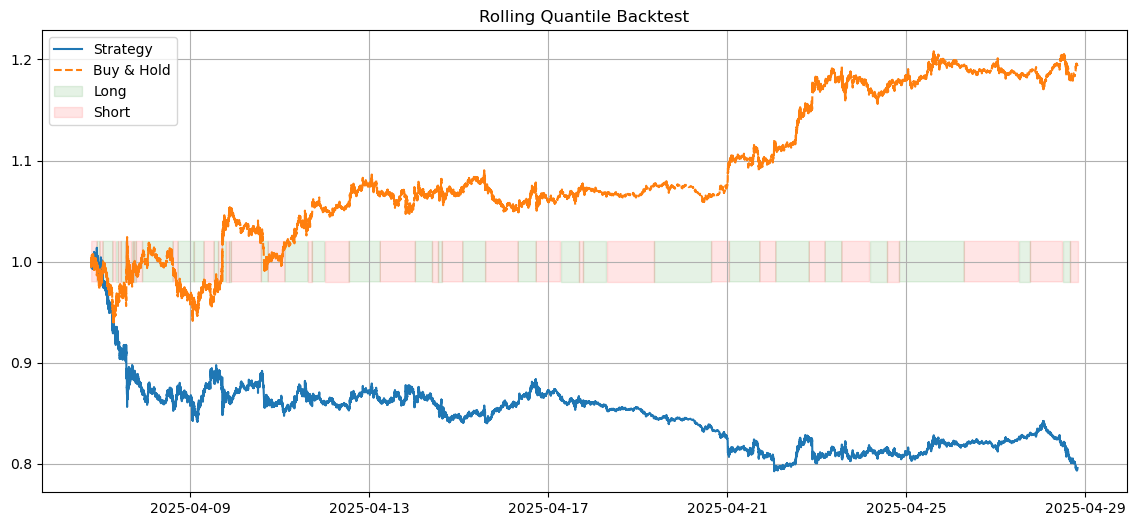

In [122]:
factor = 'alt_top_long_short_account_ratio_data_longShortRatio_SPREAD_X_MAG_alt_factor_short_term_oi_trend'
a = single_asset_rolling_quantile_backtest(
    cleaned_df.to_pandas(),
    signal_col=factor,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.9,
    short_quantile=0.1,
    window=500,
    fee=0.001,
    signal_mode="reverse",
)



📊 策略绩效指标:
总交易次数: 83
总手续费: 0.0830（费率: 0.0010）
胜率: 54.22%
总收益: 6.22%
夏普比率: 0.00
最大回撤: 10.96%


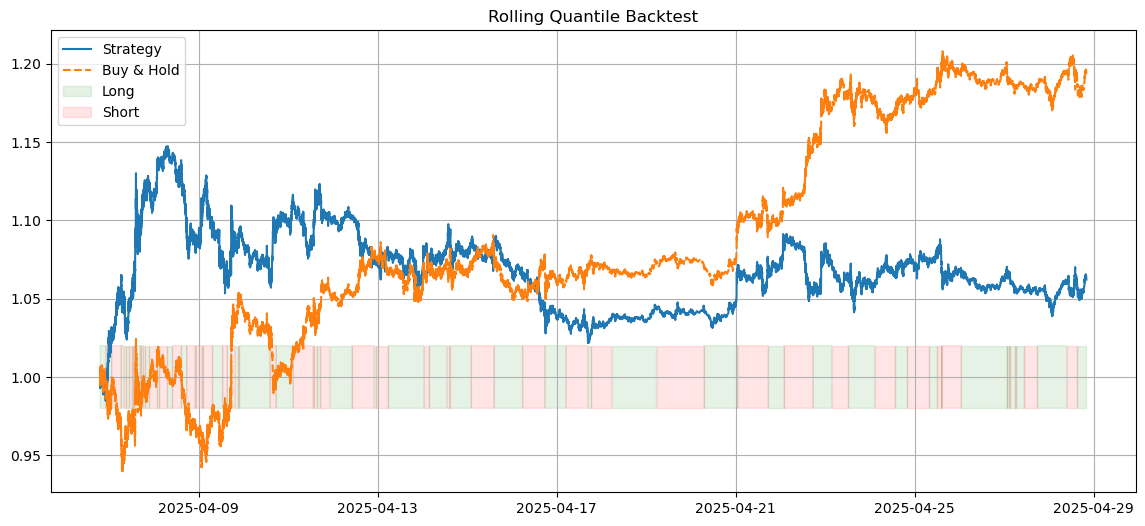

In [134]:
a = single_asset_rolling_quantile_backtest(
    cleaned_df.to_pandas(),
    signal_col=factor,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.55,
    short_quantile=0.45,
    window=500,
    fee=0.001,
)

In [202]:
def cal_z_score(x: pl.Expr, mean: pl.Expr, std: pl.Expr) -> pl.Expr:
    return (x - mean) / std

def scaled_sigmoid_expr(x: pl.Expr, start: pl.Expr, end: pl.Expr) -> pl.Expr:
    n = (start - end).abs()
    score = pl.lit(2) / (
            pl.lit(1) + (pl.lit(2.71828) ** (-pl.lit(4_000_000).log(10) * ((x - start - n) / n) + pl.lit(5e-3).log(10)))
    )
    return score / pl.lit(2)

def rolling_scaled_sigmoid_expr(
        x: str,
        mean_col: str,
        std_col: str,
        max_col: str,
        min_col: str,
) -> pl.Expr:
    return (
        pl.when(pl.col(std_col) == 0)
        .then(pl.lit(0.5))
        .otherwise(
            scaled_sigmoid_expr(
                cal_z_score(pl.col(x), pl.col(mean_col), pl.col(std_col)),
                pl.col(min_col),
                pl.col(max_col)
            )
        )
        .alias(f"{x}_scaled")  # 列命名
    )

def rolling_sum_expr(col_name: str, window: int) -> pl.Expr:
    return pl.col(col_name).rolling_sum(window).alias(f"{col_name}_sum_{window}")

def rolling_normalize_data(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
        and not col.startswith("future_return_")
        and not col.endswith('_scaled')  # scaled 是最终产物，保留
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_rolling_max') or
            col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_mean(window).alias(f"{column}_rolling_mean"),
            pl.col(column).rolling_std(window).alias(f"{column}_rolling_std"),
            pl.col(column).rolling_max(window).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
        f"{column}_rolling_mean" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_std" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_max" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_min" for column in columns_to_normalize
    ]

    normalized_df = (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_scaled_sigmoid_expr(
                column,
                f"{column}_rolling_mean",
                f"{column}_rolling_std",
                f"{column}_rolling_max",
                f"{column}_rolling_min",
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

    return normalized_df

def rolling_minmax_scaled_expr(
    col: str,
    min_col: str,
    max_col: str,
    scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .alias(scaled_col)
    )
    
def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
        and not col.startswith("future_return_")
        and not col.endswith('_scaled')  # scaled 是最终产物，保留
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_rolling_max') or
            col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window).alias(f"{column}_rolling_min"),
        ])


    intermediate_cols = [
        f"{column}_rolling_max" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_min" for column in columns_to_normalize
    ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )


In [240]:
import polars as pl
import numpy as np

np.random.seed(42)
n = 200

df = pl.DataFrame({
    "timestamp": np.arange(n),

    # 围绕 1 波动（例如：buy/sell ratio）
    "ratio_feature": np.abs(np.random.randn(n) * 1 + 1.0),

    # 围绕 100 波动（如价格）
    "price_feature": np.cumsum(np.random.randn(n) * 0.3 + 0.1),

    # 围绕 500000 波动（如资金流量）
    "fund_feature": np.cumsum(np.random.randn(n) * 1e4 + 500_000),
})


     timestamp  ratio_feature  price_feature  fund_feature  \
0            0       1.496714       0.207336  4.840557e+05   
1            1       0.861736       0.475572  9.780620e+05   
2            2       1.647689       0.900487  1.478114e+06   
3            3       2.523030       1.316628  1.978584e+06   
4            4       0.765847       1.003327  2.474084e+06   
..         ...            ...            ...           ...   
195        195       1.385317      24.522887  9.784185e+07   
196        196       0.116143      24.108947  9.833915e+07   
197        197       1.153725      24.615108  9.882936e+07   
198        198       1.058209      24.680746  9.932492e+07   
199        199       0.142970      25.152091  9.982869e+07   

     ratio_feature_scaled  price_feature_scaled  fund_feature_scaled  
0                     NaN                   NaN                  NaN  
1                     0.0                   1.0                  1.0  
2                     1.0                 

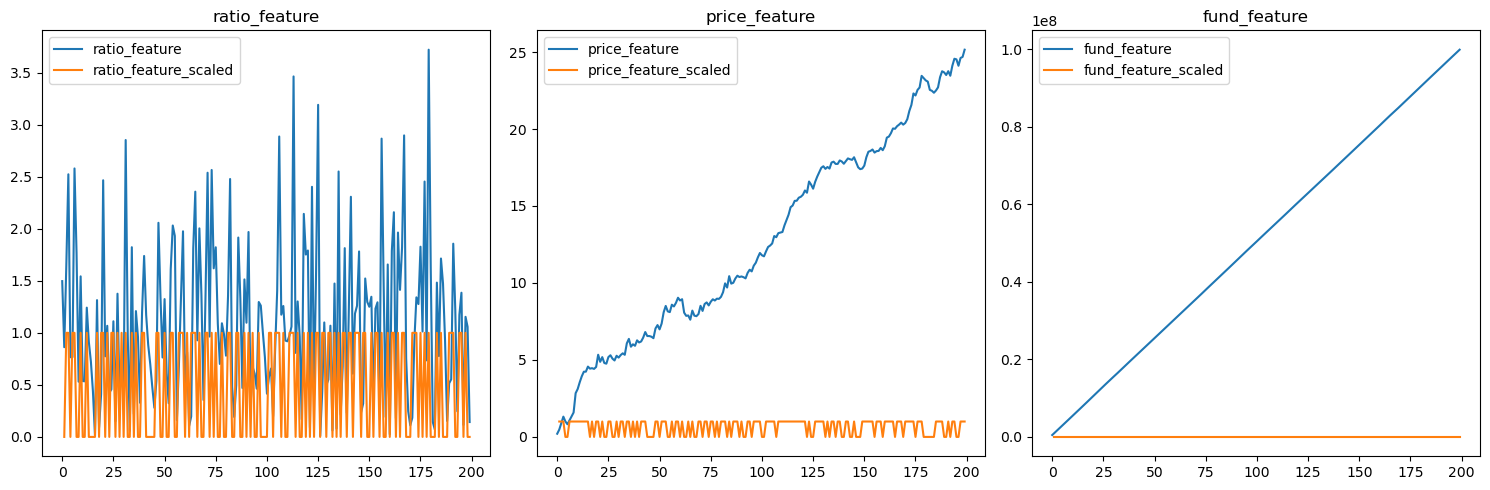

In [250]:
import matplotlib.pyplot as plt

normalized_df = rolling_minmax_normalize(df, window=2).to_pandas()
print(normalized_df)
plt.figure(figsize=(15, 5))

for i, feature in enumerate(["ratio_feature", "price_feature", "fund_feature"]):
    plt.subplot(1, 3, i+1)
    plt.plot(normalized_df[f"{feature}"], label=feature)
    plt.plot(normalized_df[f"{feature}_scaled"], label=f"{feature}_scaled")
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()


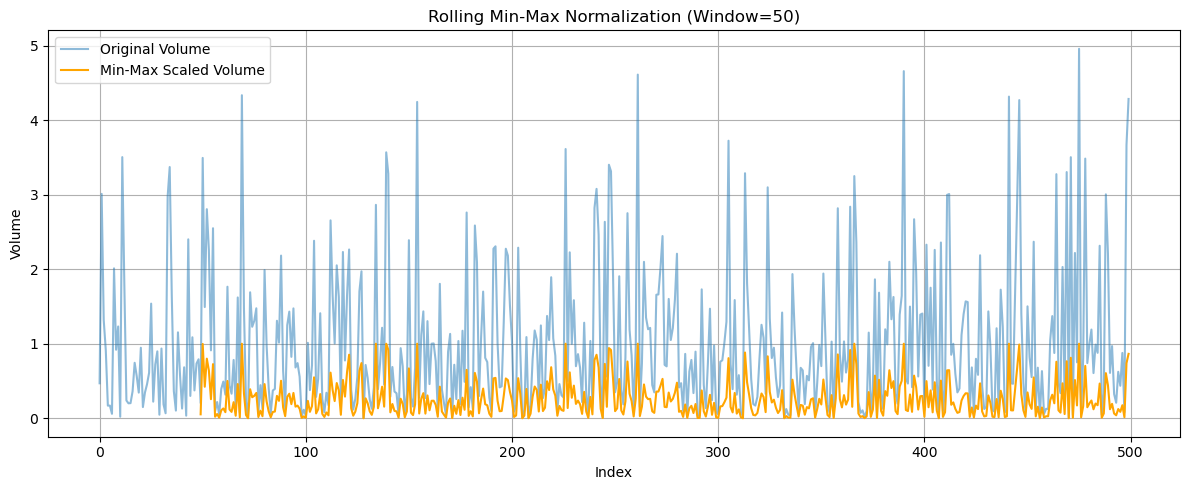

In [258]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# 示例数据
np.random.seed(42)
n_rows = 500

df = pl.DataFrame({
    "idx": np.arange(n_rows, dtype=np.int64), # 使用 i64 类型的时间戳
    "factor": np.random.rand(n_rows) * 100,
    "future_return": np.random.randn(n_rows) * 0.01 # 随机收益
})

# 为了演示负相关，我们可以稍微调整一下 future_return
df = df.with_columns(
    (pl.col("future_return") - (pl.col("factor") / 1000 - 0.05)).alias("future_return")
)

# 确保 'idx' 列已排序，这是 rolling 的要求
df = df.sort("idx")

# 定义滚动窗口大小
window_size = 30

# --- 计算滚动 Spearman IC ---

# 自定义函数：在每个组内计算 Spearman 相关性
def calculate_spearman_in_window(df_window: pl.DataFrame) -> pl.DataFrame:
    if len(df_window) < 2: # 相关性至少需要两个数据点
        return pl.DataFrame({"rolling_ic": [np.nan]})

    # 转换为Series，然后计算排名
    factor_ranks = df_window["factor"].rank(method="average")
    future_return_ranks = df_window["future_return"].rank(method="average")

    # 计算 Pearson 相关性，这就是 Spearman 相关性
    spearman_corr = factor_ranks.corr(future_return_ranks, method="pearson")

    # 确保返回的DataFrame的列名和类型与预期一致
    return pl.DataFrame({"rolling_ic": [spearman_corr]}, schema={"rolling_ic": pl.Float64}) # <-- 确保这里有明确的schema定义

# 使用 rolling().agg() 和 map_groups 来应用自定义函数
df_with_rolling_ic = df.rolling(
    index_column="idx",
    period=f"{window_size}i",
    closed="right"
).agg(
    # 修正：移除 map_groups 的 schema 参数，让 Polars 自行推断或在函数内部返回的DataFrame中明确
    pl.map_groups(
        exprs=[pl.col("factor"), pl.col("future_return")],
        function=calculate_spearman_in_window,
        # schema={"rolling_ic": pl.Float64} # <-- 移除这个参数
    ).alias("rolling_ic_computed") # 可以给一个临时的alias，如果需要的话
)

# 合并回原始DataFrame (如果需要)
# 注意：join 时使用 map_groups 返回的列名
df = df.join(df_with_rolling_ic, on="idx", how="left")

# 如果你之前没有在 calculate_spearman_in_window 中为输出列命名，
# 并且 map_groups 也没有指定 alias，那么输出列名可能会是 'map' 或其他默认名。
# 在这里，我们修改了 calculate_spearman_in_window 确保它返回 'rolling_ic' 列。
# 并且 map_groups 的 alias 设置为 "rolling_ic_computed"，所以这里需要调整
# 让我们把 map_groups 的 alias 设为最终想要的列名，或者让它不命名，然后后面重命名。
# 为了简洁，我们让 map_groups 返回的列名就是我们想要的，然后 join。

# 重新修改 df_with_rolling_ic 的生成，确保列名一致性
# 这里最简单的方法是让 calculate_spearman_in_window 函数的输出DataFrame就叫 'rolling_ic'
# 然后 map_groups 出来的结果也叫 'rolling_ic'
df_with_rolling_ic = df.rolling(
    index_column="idx",
    period=f"{window_size}i",
    closed="right"
).agg(
    pl.map_groups(
        exprs=[pl.col("factor"), pl.col("future_return")],
        function=calculate_spearman_in_window,
    ).alias("rolling_ic") # <-- 直接在这里给最终的列名
)

# 合并回原始DataFrame (如果需要)
df = df.join(df_with_rolling_ic, on="idx", how="left")

print("DataFrame with Rolling Spearman IC:")
print(df.head())
print(df.tail())

# 检查结果
print("\nRolling IC Description:")
print(df["rolling_ic"].describe())

# 绘制滚动IC
plt.figure(figsize=(15, 6))
plt.plot(df["idx"], df["rolling_ic"])
plt.title(f"{window_size}-Period Rolling Spearman IC (i64 Index)")
plt.xlabel("Index (i64 Time)")
plt.ylabel("Rolling IC")
plt.grid(True)
plt.show()

PanicException: python function failed: list indices must be integers or slices, not str